In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input 


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Keras modules for model building
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
def bottleneck_block(x, filters, kernel_size=3, stride=1, expansion=4):
    shortcut = x

    x = Conv2D(filters, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * expansion, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters * expansion, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


In [3]:
def resnet_block(x, filters, blocks, stride=1):
    x = bottleneck_block(x, filters, stride=stride)
    for _ in range(1, blocks):
        x = bottleneck_block(x, filters, stride=1)
    return x

def ResNet50(input_shape=(299, 299, 3), num_classes=1000):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, filters=64, blocks=3, stride=1)
    x = resnet_block(x, filters=128, blocks=4, stride=2)
    x = resnet_block(x, filters=256, blocks=6, stride=2)
    x = resnet_block(x, filters=512, blocks=3, stride=2)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [4]:
model = ResNet50()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 150, 150,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 75,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │      4,096 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │     36,864 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 75, 75,    │     16,384 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │     16,384 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 75, 75,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 75, 75,    │          0 │ add[0][0]       

 Total params: 23,567,299 (89.90 MB)

 Trainable params: 23,514,179 (89.70 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [5]:
# --- Data Preparation ---

# Define the data directory
data_dir = '/kaggle/input/wikiart/'

# Load the class information
class_df = pd.read_csv(os.path.join(data_dir, 'classes.csv'))

# Select three art styles
selected_styles = ['Romanticism', 'Expressionism', 'Post_Impressionism']
class_df = class_df[class_df['genre'].isin(selected_styles)]

# Create a new class-to-index mapping
class_to_index = {style: i for i, style in enumerate(selected_styles)}
num_classes = len(class_to_index)

# Define image dimensions
img_width, img_height = 299, 299  # Xception's expected input size

In [6]:
# --- Data Augmentation and Generators ---
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and preprocessing with more aggressive augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    data_dir, 
    target_size=(img_width, img_height), 
    batch_size=32, 
    class_mode='categorical', 
    classes=list(class_to_index.keys()), 
    subset='training',
    shuffle=True,
    seed=42
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    classes=list(class_to_index.keys()),
    subset='validation',
    shuffle=False
)

Found 16165 images belonging to 3 classes.
Found 4040 images belonging to 3 classes.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

In [8]:
# --- Train the Model ---

# Train the model with the callbacks
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734548681.272124      64 service.cc:145] XLA service 0x79e69c003100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734548681.272178      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734548708.470600      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


506/506 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - accuracy: 0.4491 - loss: 1.3296 - val_accuracy: 0.4101 - val_loss: 1.1997 - learning_rate: 0.0010
Epoch 2/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 632s 1s/step - accuracy: 0.5252 - loss: 0.9930 - val_accuracy: 0.3800 - val_loss: 1.3899 - learning_rate: 0.0010
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - accuracy: 0.5456 - loss: 0.9563 - val_accuracy: 0.3950 - val_loss: 1.5499 - learning_rate: 0.0010
Epoch 4/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 635s 1s/step - accuracy: 0.5691 - loss: 0.9058 - val_accuracy: 0.4119 - val_loss: 2.0710 - learning_rate: 0.0010
Epoch 5/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.6106 - loss: 0.8358 - val_accuracy: 0.5688 - val_loss: 0.9422 - learning_rate: 1.0000e-04
Epoch 6/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.6315 - loss: 0.8042 - val_accuracy: 0.5993 - val_loss: 0.9114 - learning_rate: 1.0000e-04
Epoch 7/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.6349 - loss: 0.793

127/127 ━━━━━━━━━━━━━━━━━━━━ 126s 972ms/step
Classification Report:
                    precision    recall  f1-score   support

       Romanticism       0.63      0.73      0.67      1403
     Expressionism       0.61      0.46      0.52      1347
Post_Impressionism       0.58      0.62      0.60      1290

          accuracy                           0.60      4040
         macro avg       0.60      0.60      0.60      4040
      weighted avg       0.60      0.60      0.60      4040



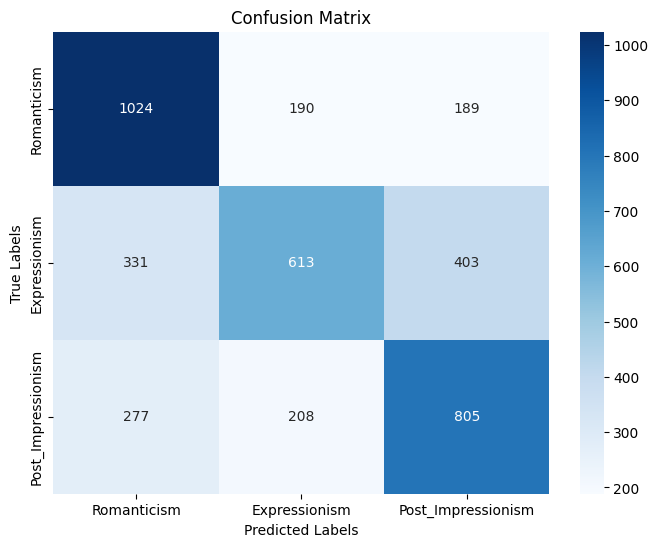

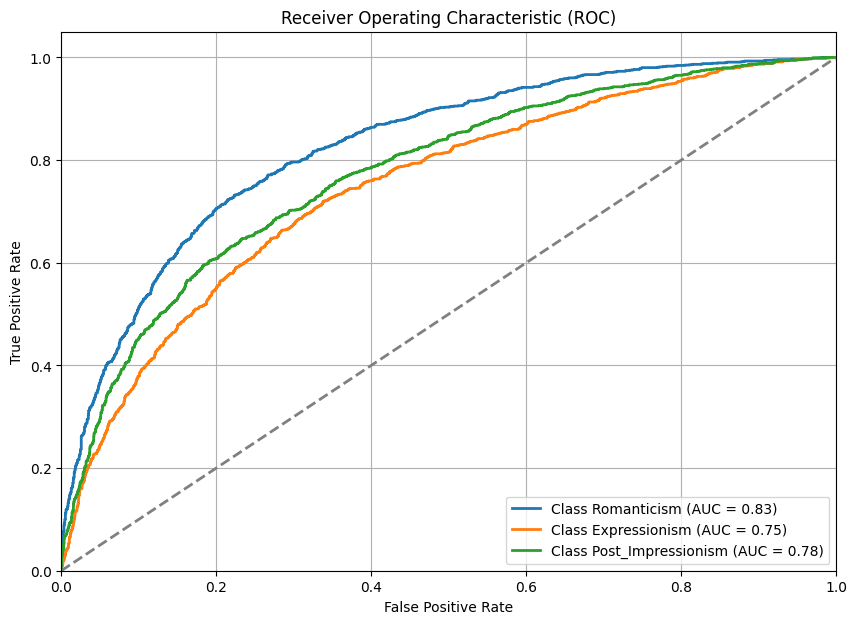

In [9]:
# --- Model Evaluation - Compute Metrics ---

# Predict the classes on the validation dataset
validation_generator.reset()  # Ensure we start from the beginning of data
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(class_to_index.keys())

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate ROC and AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], '--', lw=2, color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()